In [2]:
#%%
#python 3.8
import datetime
from astropy.units import equivalencies
import numpy as np
try:
    from galpy.util import coords
except:
    from galpy.util import bovy_coords as coords
import gala.coordinates as gcoords
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib
import pickle
import pandas as pd
from mpl_toolkits import mplot3d
import os
import glob
from scipy.signal import find_peaks

In [3]:
!hostname

c414-043.stampede2.tacc.utexas.edu


In [4]:
class SimHandler(object):
    

    def __init__(self, sim, *args,**kwargs):
        print('start init at: '+str(datetime.datetime.now()),flush=True)
        
        self.verbose = 0 #default verbosity is zero but can go up to like 4 or 5

        #path info defaults
        self.path = '/work2/07428/binod/stampede2/LRBB-IoMW/'
        self.db = 'data*'
        self.sim = str(sim)
        
        
        self.recenter = False
        
        
        
        if self.sim == 'D2':
            self.pointfpath = '/work2/07428/binod/stampede2/LRBB-IoMW_pointer_files/' #path for pointer .npy files

            #self.ntot = 1279999360
            #self.ndark=1003921280
            #self.nstar= 276078080 
            self.ntot=9333809
            self.ndark=3337406
            self.nstar=5996403
            #self.ntot = None
            #self.ndark= None
            #self.nstar= None
            self.masscutoff = 400 #mass flag boundary between bulge and disk 
            
        
            
        if self.sim != 'D2':
            print('Requested simulation is not in the list of hosted simulations (M1, M2, D1, or D2). No known', 
                  'parameters on hand. Proceed at your own risk.',
                  'Numbers of particles will be computed on-the-fly. A pointer path must be specified')
            self.pointfpath = None
        
            #initial values as determined by BN-2 simulation
            # there are 219,607,640 star particles in the disk, 21,960,680 in the bulge, 
            #and 153,599 in the dwarf satellite -- aka a total of 241,721,919 stars
            # there are 878431120 dark particles in big galaxy, 2880684 in the satellite
            self.ntot = None
            self.ndark= None
            self.nstar= None
            self.masscutoff = 400 #mass flag boundary between bulge and disk 
        
        #set a string to be appended into save formats
        self.savestr=''

        #simulation data output info
        #self.ncores = None #number of cores the particles are spread between, M1 is 24, D2 is 32
        self.ncores = 8 #number of cores the particles are spread between, M1 is 24, D2 is 32


        #params for functions
        self.targetangle = 0 #for the bar frame adjustment target
        self.downsamplefrac = 0.00005 #fraction to downsample to
        self.downsamplen = None #if this is set it will take priority over the downsample frac option
        self.find_angle_rbounds = [1.5,2.5] #r bounds to compute the fft for determining the bar location, all in kpc
        self.find_angle_m = 2#looking for the m=2 mode


        #boolean loading type params
        self.wdm = 0 #toggle in dark matter or not
        self.barframe = 0 #default is to not load in the bar frame
        self.kmpers = 1 #set params as km/s, there's really no reason to change this ever in my opinion
        self.sort = 1 #sort in creating the pointers and assume that the pointers are sorted, you should never change this

        #default bounds for grabbing particles or snaps
        self.start = 0
        self.finish = None
        self.times = None #this will be made during the init

        #load the pattern speeds for the array
        self.patternspeeds = None 

        #data types
        self.infodtype = [('time','d'),('n','i'),('ndim','i'),('ng','i'),('nd','i'),('ns','i'),('on','i')]
        self.stellardtype = [('mass','f'), ('x','f'), ('y','f'), ('z','f'), ('vx','f'), ('vy','f'), ('vz','f'), ('metals','f'), ('tform','f'), ('ID','Q')]
        self.dmdtype = [('mass','f'), ('x','f'), ('y','f'), ('z','f'), ('vx','f'), ('vy','f'), ('vz','f'), ('ID','Q')]

        #data types for saving any snap or particle
        #self.commondtype = [('t','d'),('x','f'), ('y','f'), ('z','f'), ('vx','f'), ('vy','f'), ('vz','f'), ('vr','f'), ('vphi','f'), ('vzz','f'), ('r','f'), ('phi','f'), ('zz','f'), ('mass','f'), ('idd','Q')]
        
        self.commondtype = [('t','d'),('x','f'), ('y','f'), ('z','f'), ('vx','f'), ('vy','f'), ('vz','f'),  ('mass','f'), ('idd','Q')]
        
        #this one should never be accessed, there are a couple old files though that may be in this format -- if needed though it's here
        self.oldsnapdtype = [('t','d'), ('idd','Q'),('x','f'), ('y','f'), ('z','f'), ('vx','f'), ('vy','f'), ('vz','f'), ('vr','f'), ('vphi','f'), ('vzz','f'), ('r','f'), ('phi','f'), ('zz','f'), ('mass','f')]


        #data type for the pointer files that particle tracing functions use
        self.pointdtype = [('idd','Q'),('core','H'), ('db1', 'H'),('db2', 'H'), ('seek','I')] ####need to add in which DB!
        self.errrange = 200 #default range to look on either side of where something /should/ be in a pointer file
        self.approxhalofrac = .1 #approximage halo fraction of the stellar population to speed up pointer file use

        #if not(os.path.isdir('plots')):
        #    print('Making plots/ directory for output figures.', flush=True)
         #   os.path.mkdir('plots')

        print('end at: '+str(datetime.datetime.now()),flush=True)

    def gettimes(self, return_array=False):
        path_01 = self.path
        if self.times is None:
            try:
                self.times = sorted(glob.glob(path_01+'snapshot*-0')) #remember! glob is not sorted!
                for ii,t in enumerate(self.times):
                    self.times[ii] = t.split('/')[-1]
            except:
                self.times = 'snapshot__00000.0000-0'
        
        if return_array == True:
            return self.times
                
    def timestot(self,s):
        return(float(s.split('-')[-2].split('_')[-1])*9.778145/1000.) #Gyr 

    def loadpatternspeeds(self):
        #try to load the pattern speed array for this sim if it's available
        if self.patternspeeds is None:
            try:
                self.patternspeeds = np.load(self.pointfpath+'patternspeed.npy')
            except:
                print('ATTN: Cannot load pattern speeds because file does not exist for this simulation at %s'%self.path, flush=True)

    #%%
    def printnow(self):
        print('check: '+str(datetime.datetime.now()),flush=True)

    #loaders
    #% load one snapshot
    def loader(self,filename,infoonly=0,forcedarkmatter=None):
        """
        loads an individual time snapshot from an individual node 
        converts to physical units

        Inputs
        ------------------
        filename (str): path to file of snapshot
        wdm (boolean): with dark matter toggle, will get stars and dark matter

        Returns
        ------------------
        cats (np.ndarray): stars [mass value for disk or bluge (float32), x position(float32),
                                y position (float32), z position (float32), vx x velocity(float32),
                                vy y velocity(float32), vz z velocity(float32), metals (float32),
                                tform (float), ID (uint64)]
        if self.wdm==True: 
            returns tuple with (catd,cats,info) where catd (np.ndarray): dark matter particles [same as above]
        """
        catd = []
        cats = []
        with open(filename, 'rb') as f:
            if infoonly == True:
                if self.verbose>1:
                    print(filename)
                #file info
                info= np.fromfile(f,dtype=self.infodtype,count=1)
                infoBytes = f.tell()
                if self.verbose>2:
                    print(infoBytes)
            elif self.wdm == False:
                if self.verbose>1:
                    print(filename)
                #file info
                info= np.fromfile(f,dtype=self.infodtype,count=1)
                infoBytes = f.tell()
                if self.verbose>2:
                    print(infoBytes)
                #skip darkmatter
                #read the first dm line
                if self.verbose>2:
                    print(f.tell())
                catd = np.fromfile(f,dtype=self.dmdtype, count=1)   
                #get the bytes location and subtract off the bytes location after loading info to get n bytes a line for dm
                if self.verbose>2:
                    print(f.tell())
                current = f.tell()
                dmBytes = current-infoBytes
                f.seek(dmBytes*(info['nd'][0]-1)+current)
                if self.verbose>2:
                    print(f.tell())
                # stars setup                    
                cats= np.fromfile(f,dtype=self.stellardtype, count=info['ns'][0])
                if self.verbose>2:
                    print('done')
            else:
                if self.verbose>1:
                    print(filename)
                #file info
                info= np.fromfile(f,dtype=self.infodtype,count=1)
                if self.verbose>2:
                    print(f.tell())
                #dark matter setup count is reading the number of rows
                catd= np.fromfile(f,self.dmdtype, count=info['nd'][0]) 
                if self.verbose>2:
                    print(f.tell())                   
                # stars setup                    
                cats= np.fromfile(f,dtype=self.stellardtype, count=info['ns'][0])
                if self.verbose>2:
                    print('done')
            
        if infoonly == False:
            #convert to physical units as found in README.md
            if self.wdm == True:
                catd['mass']*=2.324876e9
                if self.kmpers == 1:
                    catd['vx']*=100.
                    catd['vy']*=100.
                    catd['vz']*=100.
            cats['mass']*=2.324876e9
            if self.kmpers == True:
                    cats['vx']*=100.
                    cats['vy']*=100.
                    cats['vz']*=100.
        
        if (self.wdm == True) or (forcedarkmatter==True):
            return(catd,cats,info)
        else:
            return(cats,info)

    #% load one whole timestep, load a single snap
    def loadwholesnap(self,timestepid,forcebarframe=None,forcedarkmatter=None):
        
        #check that times exists
        self.gettimes()
        #times = simD2.gettimes(return_array=True)
        times = self.gettimes(return_array=True)
        #print(times)
        if self.kmpers != 1:
            print('ATTN: Enabled 100 km/s units instead of km/s for velocities.')
        
        c = 8
        coreid_array=np.arange(0,8,1)
        #if the number of total, dark, and stellar particles are not set then determine
        if self.ncores is None:
            self.ncores = c
        if self.ntot==None:
            self.ntot=info['n']
            self.ndark=info['nd']
            self.nstar=info['ns']
            if self.ncores is None:
                self.ncores = c
            
        #now load the first core for information and to start filling the array
        coreid = coreid_array[0]
        if self.verbose > 1:
            print('\nLoading (also to set info) ', self.path+self.times[timestepid][:-1]+str(coreid), flush=True)
        if (self.wdm == True) or (forcedarkmatter==True):
            catd,cats,info=self.loader(self.path+self.times[timestepid][:-1]+str(coreid),forcedarkmatter=forcedarkmatter)

        else:
            cats,info=self.loader(self.path+self.times[timestepid][:-1]+str(coreid))

        if self.verbose > 1:
            print(info['n'],info['ns'],info['nd'], flush=True)

        if self.verbose > 2:
            print(self.ntot,self.ndark,self.nstar, flush=True) 

        #allocate for the snap arrays    
        snaparr = np.empty(self.nstar,dtype=self.commondtype)  
        if (self.wdm == True) or (forcedarkmatter==True):
            snaparr_dark = np.empty(self.ndark,dtype=self.commondtype)

        tnstar=int(info['ns'])
        if (self.wdm == True) or (forcedarkmatter==True):
            tndark=int(info['nd'])

        snaparr['x'][0:tnstar]=cats['x']
        snaparr['y'][0:tnstar]=cats['y']
        snaparr['z'][0:tnstar]=cats['z']
        snaparr['vx'][0:tnstar]=cats['vx']
        snaparr['vy'][0:tnstar]=cats['vy']
        snaparr['vz'][0:tnstar]=cats['vz']
        snaparr['mass'][0:tnstar]=cats['mass']
        snaparr['idd'][0:tnstar]=cats['ID']
        snaparr['t'][0:tnstar]=info['time']*9.778145/1000.

        arrayindx=tnstar

        if (self.wdm == True) or (forcedarkmatter==True):
            snaparr_dark['x'][0:tndark]=catd['x']
            snaparr_dark['y'][0:tndark]=catd['y']
            snaparr_dark['z'][0:tndark]=catd['z']
            snaparr_dark['vx'][0:tndark]=catd['vx']
            snaparr_dark['vy'][0:tndark]=catd['vy']
            snaparr_dark['vz'][0:tndark]=catd['vz']
            snaparr_dark['mass'][0:tndark]=catd['mass']
            snaparr_dark['idd'][0:tndark]=catd['ID']
            snaparr_dark['t'][0:tndark]=info['time']*9.778145/1000.

            arrayindx_dark = tndark


        if self.verbose > 2:
            print('stellar index is ',arrayindx, flush=True)
        for j in range(1,self.ncores):
            coreid = coreid_array[j]
            sim_path = self.path
            if self.verbose > 1:
                print('Loading '+self.path+self.times[timestepid][:-1]+str(coreid), flush=True)
            if (self.wdm == True) or (forcedarkmatter==True):
                catd,cats,info=self.loader(self.path+self.times[timestepid][:-1]+str(coreid),forcedarkmatter=forcedarkmatter)
            else:
                cats,info=self.loader(self.path+self.times[timestepid][:-1]+str(coreid))
            tnstar=int(info['ns'])
            if (self.wdm == True) or (forcedarkmatter==True):
                tndark = int(info['nd'])

            if self.verbose > 2:
                print(arrayindx,tnstar,arrayindx+tnstar, flush=True)
            snaparr['x'][arrayindx:arrayindx+tnstar]=cats['x']
            snaparr['y'][arrayindx:arrayindx+tnstar]=cats['y']
            snaparr['z'][arrayindx:arrayindx+tnstar]=cats['z']
            snaparr['vx'][arrayindx:arrayindx+tnstar]=cats['vx']
            snaparr['vy'][arrayindx:arrayindx+tnstar]=cats['vy']
            snaparr['vz'][arrayindx:arrayindx+tnstar]=cats['vz']
            snaparr['idd'][arrayindx:arrayindx+tnstar]=cats['ID']
            snaparr['mass'][arrayindx:arrayindx+tnstar]=cats['mass']
            snaparr['t'][arrayindx:arrayindx+tnstar]=info['time']*9.778145/1000.

            arrayindx=arrayindx+tnstar

            if (self.wdm == True) or (forcedarkmatter==True):
                snaparr_dark['x'][arrayindx_dark:arrayindx_dark+tndark]=catd['x'] 
                snaparr_dark['y'][arrayindx_dark:arrayindx_dark+tndark]=catd['y'] 
                snaparr_dark['z'][arrayindx_dark:arrayindx_dark+tndark]=catd['z'] 
                snaparr_dark['vx'][arrayindx_dark:arrayindx_dark+tndark]=catd['vx'] 
                snaparr_dark['vy'][arrayindx_dark:arrayindx_dark+tndark]=catd['vy'] 
                snaparr_dark['vz'][arrayindx_dark:arrayindx_dark+tndark]=catd['vz']
                snaparr_dark['idd'][arrayindx_dark:arrayindx_dark+tndark]=catd['ID']
                snaparr_dark['mass'][arrayindx_dark:arrayindx_dark+tndark]=catd['mass']
                snaparr_dark['t'][arrayindx_dark:arrayindx_dark+tndark]=info['time']*9.778145/1000.

                arrayindx_dark=arrayindx_dark+tndark

            #except:
            #    print(times[i]+'-'+str(j),'has no star particles', flush=True)
        if self.recenter == True:
            snaparr = self.apply_recen_snap(snaparr) 

        #move into bar frame if true
        if (self.barframe == True) or (forcebarframe==True):
            #check for path
            if os.path.exists(self.pointfpath+'patternspeed.npy'):
                snaparr = self.intobarframe(snaparr,frame=timestepid)
                if (self.wdm == True) or (forcedarkmatter==True):
                    snaparr_dark = self.intobarframe(snaparr_dark,frame=timestepid)
            else: #this is so inefficient never use it and intobarframe isnt set up for it -- okay but what about with the smaller sims?
                print('ATTN: skipping moivng into bar pattern frame because speeds not computed yet')
                # pspeed = getpatternspeed(path,timestepid,inputsnaparr=snaparr,verbose=verbose,withbarangle=1) #also in radperGyr
                # snaparr = intobarframe(snaparr,timestepid)
        if (self.wdm == True) or (forcedarkmatter==True):
            return(snaparr,snaparr_dark)
        else:
            return(snaparr)

    #% load whole pickle step
    def loadstep(self,timestepid):
        fstr = self.path+'step'+str(timestepid)+'.p'
        
        #load the pickle
        with open(fstr,'rb') as f:
            idd,x,y,z,vx,vy,vz,mass = pickle.load(f)
        
        return (idd,x,y,z,vx,vy,vz,mass)

    

In [5]:
%%time 
sim = 'D2' #the name of the simulation that you want to look at
simD2 = SimHandler(sim) #Make an instance (here we name the instance simM1) by calling the SimHandler class & 

#simD2.wdm = True 
simD2.recenter = False 

start init at: 2022-03-30 00:17:03.953405
end at: 2022-03-30 00:17:03.956630
CPU times: user 6.98 ms, sys: 2.99 ms, total: 9.97 ms
Wall time: 6.24 ms


In [6]:
times = simD2.gettimes(return_array=True)
snapshot=500
snapshot_name = times[snapshot] #indexing starts at zero - 702 gives us 703rd item
print('we have selected', snapshot_name)
print('this name is a', type(snapshot_name)) #let's also print out the data type of snapshot_name

we have selected snapshot__00501.0006-0
this name is a <class 'str'>


In [7]:
print(times[0:10])
print(times[-10:])

['snapshot__00001.0010-0', 'snapshot__00002.0000-0', 'snapshot__00003.0010-0', 'snapshot__00004.0009-0', 'snapshot__00005.0008-0', 'snapshot__00006.0007-0', 'snapshot__00007.0007-0', 'snapshot__00008.0006-0', 'snapshot__00009.0000-0', 'snapshot__00010.0004-0']
['snapshot__00501.0006-0', 'snapshot__00502.0006-0', 'snapshot__00503.0006-0', 'snapshot__00504.0007-0', 'snapshot__00505.0007-0', 'snapshot__00506.0007-0', 'snapshot__00507.0008-0', 'snapshot__00508.0008-0', 'snapshot__00509.0008-0', 'snapshot__00510.0009-0']


In [15]:
%%time
#%%time 
#v_circ=simD2.getrotationcurve(snapshot,savepath="./")

#Estimated time
#CPU times: user 2h 16min 21s, sys: 31min 28s, total: 2h 47min 50s
#Wall time: 2h 48min 4s
snaparr, snaparr_dark= simD2.loadwholesnap(snapshot,forcedarkmatter=True)
#getting r for snaparr and snaparr_dark

CPU times: user 986 ms, sys: 181 ms, total: 1.17 s
Wall time: 1.17 s


In [9]:
print(snaparr)

[(4.89885631, -592.11316, -526.0686 , -104.610825, -86.33299  , -63.75918 , -32.78896  , 4496.5737, 5971549)
 (4.89885631, -261.80176, -705.5607 , -251.84921 , -36.052998 , -78.20662 , -54.262012 , 4496.5737, 5330678)
 (4.89885631, -148.63768, -571.8685 , -231.02306 ,  -3.5719945, -49.127537, -76.6207   , 4496.5737, 5174864)
 ...
 (4.89885631, -232.42381, -495.62756,  315.80933 , -37.037323 , -38.67214 ,  29.880997 , 4496.5737, 5117453)
 (4.89885631, -263.51428, -529.08575,   45.308064, -11.793718 , -48.103992,   3.3363853, 4496.5737, 5285016)
 (4.89885631, -519.8585 , -575.40375,  237.57957 , -70.12581  , -94.09911 ,  11.202039 , 4496.5737, 5539122)]


In [10]:
#print(snaparr["x"])
print(np.min(snaparr["mass"]))
print(np.max(snaparr["mass"]))

4496.5737
13416.486


In [11]:
print(snaparr.dtype)

[('t', '<f8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('mass', '<f4'), ('idd', '<u8')]


In [12]:
print(snaparr["t"])

[4.89885631 4.89885631 4.89885631 ... 4.89885631 4.89885631 4.89885631]


In [13]:
print(snaparr["x"])

[-592.11316 -261.80176 -148.63768 ... -232.42381 -263.51428 -519.8585 ]


x Range of star particles -853.7388 769.7483
x Range of Dark Matter particles -598.89185 5.9790683
Total star particles 5996403
Total Dark Matter particles 3337406


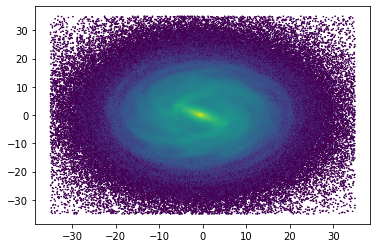

In [21]:
x=snaparr["x"]
y=snaparr["y"]

xd=snaparr_dark["x"]
yd=snaparr_dark["y"]

print("x Range of star particles",np.min(x),np.max(x))
print("x Range of Dark Matter particles",np.min(xd),np.max(xd))
print("Total star particles",len(x))
print("Total Dark Matter particles",len(xd))

#plt.hexbin(x,y,extent=((-35,35,-35,35)),gridsize=400,mincnt=1,bins="log")
plt.hexbin(x,y,extent=((-35,35,-35,35)),gridsize=400,mincnt=1,bins="log")

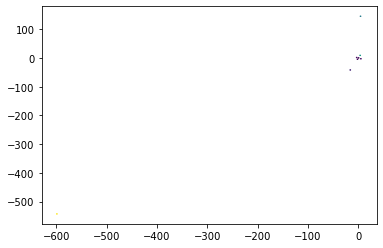

In [20]:
plt.hexbin(xd,yd,gridsize=400,mincnt=1)